# 1.Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import multivariate_normal

from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope



import warnings
warnings.filterwarnings("ignore")
import os

plt.style.use('fivethirtyeight')

In [2]:
from numpy import ma
import math
import matplotlib
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure

In [3]:
dt_file_t=pd.read_csv("C:/Users/qkrru/My_Jupyter/Competition_CreditCard/train_Card.csv")
dt_file_v=pd.read_csv("C:/Users/qkrru/My_Jupyter/Competition_CreditCard/val_Card.csv")
dt_file_s=pd.read_csv("C:/Users/qkrru/My_Jupyter/Competition_CreditCard/test_Card.csv")

# 2.ID제거

In [4]:
dt_Raw_t=dt_file_t.copy()
dt_Raw_v=dt_file_v.copy()
dt_Raw_s=dt_file_s.copy()

dt_Raw_t.drop(['ID'], axis=1, inplace=True)
dt_Raw_v.drop(['ID'], axis=1, inplace=True)
dt_Raw_s.drop(['ID'], axis=1, inplace=True)

# 3.DATA column  순서 변경

In [5]:
dt_Raw_t=dt_Raw_t[['V30','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29']]

dt_Raw_v=dt_Raw_v[['V30','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29','Class']]

dt_Raw_s=dt_Raw_s[['V30','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23','V24', 'V25', 'V26', 'V27', 'V28', 'V29']]


# 4. Traing Set Abnormal Data 제거(ISF)-----------------

In [6]:
from sklearn.ensemble import IsolationForest

dt_t_wAb=dt_Raw_t.copy()#wAb : with Abnormal
dt_t_wAb=dt_t_wAb[['V30','V1','V2','V3','V4','V5','V6','V7','V9','V10','V11','V12','V14','V16','V17','V18',
                     'V19','V20','V21','V24','V27','V28','V29']]

state=42

ISF_t=IsolationForest(n_estimators=100, random_state = state, contamination = 0.00028)#현재 최적 0.00028
ISF_t.fit(dt_t_wAb)

y_dt_wAb=ISF_t.predict(dt_t_wAb)

dt_t=dt_Raw_t.copy()
dt_t['PureClass']=y_dt_wAb
dt_t=dt_t[dt_t['PureClass']==1]
dt_t.drop(['PureClass'],axis=1, inplace=True)#32개 빠진것을 보니 너무 조금 빠진듯 하다. 아마 200개 정도 Abnormal 일 듯

# -----------------------------Feature Tuning1-----------------------------

# 5.Normalization

In [7]:
dt_t_Unorm = dt_t.copy()
dt_v_Unorm = dt_Raw_v.copy()
dt_s_Unorm = dt_Raw_s.copy()

scl = StandardScaler()
scl.fit(dt_t_Unorm)

pca_columns = list(dt_v_Unorm)[:-1]
all_cols = list(dt_v_Unorm)[:]

dt_v_Class=dt_v_Unorm['Class'].values.reshape(-1,1)
dt_v_scaled_pca=scl.transform(dt_v_Unorm[pca_columns])

dt_t = scl.transform(dt_t_Unorm)
dt_v = np.concatenate((dt_v_scaled_pca,dt_v_Class),axis=1)
dt_s = scl.transform(dt_s_Unorm)

dt_t=pd.DataFrame(dt_t, columns = pca_columns)
dt_v=pd.DataFrame(dt_v, columns = all_cols)
dt_s=pd.DataFrame(dt_s, columns = pca_columns)

# 6. Training, Test set 생성

In [8]:
tmp_dt_t = dt_t.copy()
tmp_dt_v = dt_v.copy()
tmp_dt_s = dt_s.copy()

pca_columns = list(tmp_dt_v)[:-1]
all_cols = list(tmp_dt_v)[:]

n_outliers=dt_v[dt_v['Class'] == 1].shape[0]

num_test=dt_v.shape[0]-n_outliers

normal_dt_v=dt_v.loc[dt_v['Class'] == 0]
fraud_dt_v=dt_v.loc[dt_v['Class'] == 1]

normal_pca_dt_v=normal_dt_v[pca_columns]
fraud_pca_dt_v=fraud_dt_v[pca_columns]

X_train = dt_t.copy()
X_test = np.concatenate([normal_pca_dt_v[:], fraud_pca_dt_v[:]])#뒤쪽에 abnormal데이터 몰아놨음
y_test = np.concatenate([np.zeros(num_test), np.ones(n_outliers)])

normal_pca_dt=np.concatenate([X_train[:], normal_pca_dt_v[:]])

X_test=pd.DataFrame(X_test, columns = normal_pca_dt_v.columns)
y_test=pd.DataFrame(y_test, columns = ['Class'])

print("normal_pca_dt_v ", normal_pca_dt_v.shape)
print("normal_pca_dt ", normal_pca_dt.shape)
print("fraud_pca_dt_v", fraud_pca_dt_v.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_dt_v  (28432, 30)
normal_pca_dt  (142242, 30)
fraud_pca_dt_v (30, 30)
Fraud data only in Test with NONE in the training
X_train  (113810, 30)
X_test  (28462, 30)
y_test  (28462, 1)


# 8. 모델 생성 및 평가

## 8-1. Multi-variable Gaussian

In [9]:
p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))


x = p.pdf(X_train)
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))
print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(X_test)
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))
print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(fraud_pca_dt_v)
print("max prob of x on fraud_pca_dt", max(x))
print("mean prob of x on fraud_pca_dt", np.mean(x))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)

max prob of x on X_train 6.859361904048994e-13
mean prob of x on X_train 1.8692575436749856e-14
------------------------------------------------------------
max prob of x on X_test 5.340008592807164e-13
mean prob of x on X_test 1.8861048889633823e-14
------------------------------------------------------------
max prob of x on fraud_pca_dt 2.627755974696676e-15
mean prob of x on fraud_pca_dt 1.1718539332932533e-16
------------------------------------------------------------
Difference between mean prob of Train vs Test  -1.6847345288396772e-16


### 8-1-1 Optimize Epsilon

In [10]:
x = p.pdf(X_test)

EpsF1 = []
# #1
epsilons = [1e-110, 1e-120, 1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200, 1e-210, 1e-220,
           1e-230, 1e-240, 1e-250, 1e-260, 1e-270]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()

,epsilon,F1
0,1.000000e-110,0.2273
1,1.000000e-120,0.2479
2,1.000000e-130,0.2679
3,1.000000e-140,0.2772
4,1.000000e-150,0.2828


In [11]:
EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-250
F1          3.562000e-01
Name: 14, dtype: float64

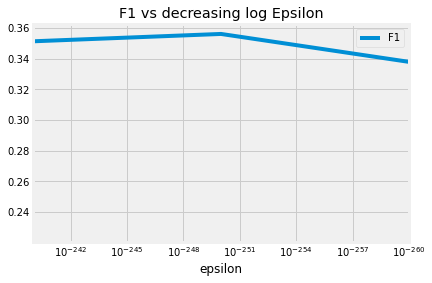

In [12]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-240, 1e-260)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

In [13]:
eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']

print("epsilon ", eps)
print("_"*50)
y_pred_GM = (x<=eps)
pred=y_pred_GM.copy()
CM = confusion_matrix(y_test,pred)
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

epsilon  1e-250
__________________________________________________
[[28402    30]
 [   17    13]]
__________________________________________________
TP  13
FP  30
TN  28402
FN  17


### 8-1-2 평가 함수 생성 및 평가

In [14]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

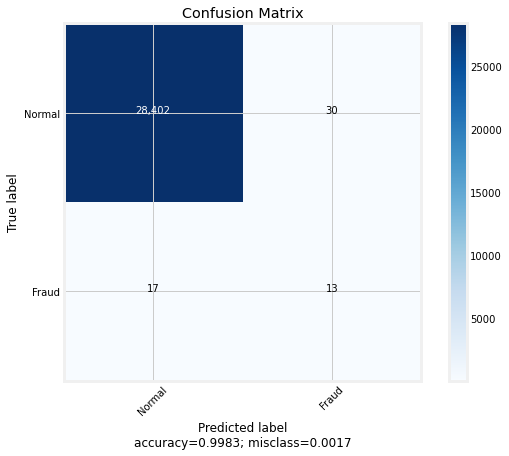

In [15]:
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

In [16]:
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test,pred, average='binary')
print("precision ", round((precision), 3))
print("recall ", round((recall), 3))
print("F1 score on Test", round((fbeta_score), 3))

precision  0.302
recall  0.433
F1 score on Test 0.356


## 8-2 Robust Covariance

In [17]:
PercFraud = (n_outliers/X_test.shape[0])

cov = EllipticEnvelope(support_fraction = 0.996, contamination = PercFraud)
clf_RC=cov.fit(X_train)

y_pred_RC=clf_RC.predict(X_test)#RC는 positive=1, negative=-1을 반환한다

ground_truth = np.ones(len(X_test), dtype=int)
ground_truth[-n_outliers:] = -1#y_test를 1,-1로 바꾼 형태
y_pred=y_pred_RC.copy()
n_errors = (y_pred != ground_truth).sum()
n_errors

9

In [18]:
PercFraud

0.0010540369615627855

### 8-2-1 평가

In [19]:
y_pred_RC = y_pred.copy()
y_predDF = pd.DataFrame(y_pred_RC)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_pred_RC = y_predDF.values
y_pred_RC = np.ravel(y_pred_RC)

precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_pred_RC, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.8621
recall  0.8333
F1 score on Test 0.8475


In [20]:
CM = confusion_matrix(y_test, y_pred_RC)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_RC).ravel()

print(CM)
print("_"*50)
print("TP ", tp)
print("FP ", fp)
print("TN ", tn)
print("FN ", fn)

[[28428     4]
 [    5    25]]
__________________________________________________
TP  25
FP  4
TN  28428
FN  5


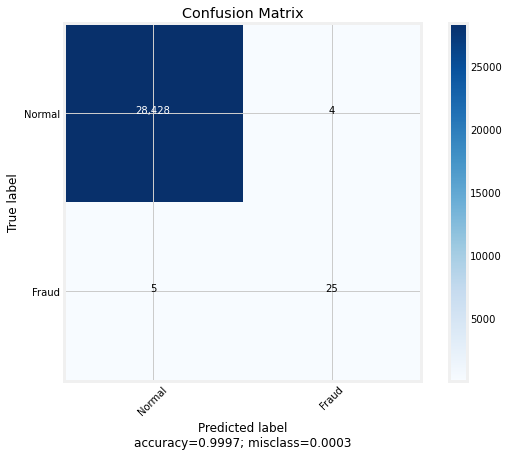

In [21]:
plot_confusion_matrix(CM, 
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

In [22]:
y_pred_RC_DF=pd.DataFrame(y_pred_RC)
y_pred_RC_DF.rename(columns ={0:'Class'},inplace=True)
un_classified_RC=y_pred_RC_DF.add(y_test)
un_classified_RC=un_classified_RC.add(y_pred_RC_DF)
un_classified_RC.Class[un_classified_RC['Class']==2]=0
un_classified_RC.Class[un_classified_RC['Class']==3]=0
un_classified_RC=un_classified_RC[un_classified_RC['Class']==1]

In [23]:
un_classified_RC

,Class
28432,1.0
28440,1.0
28444,1.0
28448,1.0
28461,1.0


### 8-3-1 평가

In [24]:
y_pred_LOF = y_pred.copy()
y_predDF = pd.DataFrame(y_pred_LOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_pred_LOF = y_predDF.values
y_pred_LOF = np.ravel(y_pred_LOF)

 # F1 Score
 #print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_pred_LOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.8621
recall  0.8333
F1 score on Test 0.8475


# SUBMISSION

In [25]:
s_pred_RC=clf_RC.predict(dt_s)
s_pred_RC = pd.DataFrame(s_pred_RC)
s_pred_RC.rename(columns = {0:'Class'}, inplace = True)
s_pred_RC.loc[s_pred_RC['Class']==1,'Class']=0
s_pred_RC.loc[s_pred_RC['Class']==-1,'Class']=1

In [26]:
s_pred_RC.value_counts()

Class
0        142192
1           311
dtype: int64

In [27]:
submission=[]
submission=pd.DataFrame(submission)
type(submission)
submission['ID']=dt_file_s['ID']
submission['Class']=s_pred_RC['Class']

In [28]:
submission.Class.value_counts()

0    142192
1       311
Name: Class, dtype: int64

In [ ]:
submission.to_csv('C:/Users/qkrru/My_Jupyter/Competition_CreditCard/submission.csv')